# SVM Model for Stroke Prediction

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

In [3]:
df = pd.read_csv('stroke_training_dataset.csv') #loading the training dataset as a pandas DataFrame

# Preprocessing

Before anything else we observe a portion of the dataset:

In [4]:
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


There are a couple of clear adaptations we want to make to the data. Firstly, the 'id' column is not a relevant feature for predicting a stroke, so we remove this. Secondly, we need to convert the categorical data in order to apply SVM. For most of the categorical features, it's good enough to use one-hot encoding. However, for the 'smoking_status' column, there are four responses: 'never smoked', 'formerly smoked', 'smokes' and 'unknown'. It's not appropriate to use one-hot encoding here, because that would make the 'formerly smoked' axis orthogonal to 'never smoked' and 'smokes'. This doesn't make any sense, so we convert this instead to a ranking, so that 'never smoked', 'formerly smoked' and 'smoker' are each mapped to numerical rankings 1,2,3 respectively. We map the 'unknown' answers to NaN values so that we can deal with them as missing data.

In [5]:
df = df.drop(['id'], axis=1) #removes the id column
smoker_quantify = {'never smoked': 1, 'formerly smoked': 2, 'smokes': 3} #we create a mapping to make people's smoking habits a numerical ranking
df['smoking_status'] = df['smoking_status'].replace(smoker_quantify) #we apply the mapping to the smoking_status column
df['smoking_status'] = pd.to_numeric(df['smoking_status'], errors='coerce') #this line converts all 'unknown' values to NaN, to make cleaning the dataset easier.

Next we one-hot encode the rest of the categorical features

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist() #selecting categorical valued columns for encoding
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[categorical_columns])  #fits and transforms the categorical values to one hot encoding

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df, one_hot_df], axis=1)

df_encoded = df_encoded.drop(categorical_columns, axis=1)

Now we want to deal with the missing / NaN values. Let's first see how many there are, and which column they belong to.

In [7]:
no_nan = df_encoded.isna().sum() # counts how many inputs are NaN in each column

percent_nan = df_encoded.isna().mean() * 100 # gives the percentage of Nan entries in a column

nan_summary = pd.DataFrame({
    'Number of NaN values': no_nan,
    'NaN percentage': percent_nan
}).sort_values(by='NaN percentage', ascending=False)

print(nan_summary.head(5))  # prints the features with most NaN values
print('shape of overall dataframe:', df.shape)

                Number of NaN values  NaN percentage
smoking_status                  1239       30.308219
bmi                              173        4.231898
age                                0        0.000000
heart_disease                      0        0.000000
hypertension                       0        0.000000
shape of overall dataframe: (4088, 11)


We see that there are far too many NaN values for us to remove every corresponding row (about a third of the overall data). Our options are to remove the 'smoking_status' column entirely, or deal with the missing values in another way. Smoking history could be quite important in predicting a stroke, and we still have 70% of the smoking history data, so we opt to impute missing values. However, missingness of smoking history may not be coincidental - it is a topic that certain people could be hesitant to answer (out of embarrassment or otherwise), and missing answers may be significant. For example, a former smoker may be more likely to not answer than a never-smoker. To account for this, we encode the missingness as its own indicator variable. Now the BMI missing data is a much smaller proportion, and is more likely to be completely random, so we just remove these datapoints.

Note on imputation: we use KNN imputation because it bases its predictions on similar rows. In this case, the other features likely do have some correlation with smoking history (e.g age), so it makes sense to estimate them based from this.

In [8]:
df_encoded['smoking_unknown'] = df_encoded['smoking_status'].isna().astype(int)
#imputer = SimpleImputer(strategy='mean') # simple imputation (alternative option)
imputer = KNNImputer(n_neighbors=5, weights='uniform')
#imputer = IterativeImputer(max_iter=10, random_state=0) (alternative option)
df_encoded['smoking_status'] = imputer.fit_transform(df_encoded[['smoking_status']])
df_encoded = df_encoded.dropna() #now we just drop the other missing value columns
df_encoded.tail(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_unknown
4082,18.0,0,0,82.85,46.9,1.691471,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4084,81.0,0,0,125.20,40.0,1.000000,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4085,35.0,0,0,82.99,30.6,1.000000,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4086,51.0,0,0,166.29,25.6,2.000000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4087,44.0,0,0,85.28,26.2,1.691471,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1


Now we've cleaned the data without losing many entries. We've gained another feature, which is fine because SVM performs well in high dimension.

Next let's subdivide our training dataset into another training and testing set, to train the SVM model and evaluate performance. We stratify the sets to deal with the imbalance in the dataset

In [31]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']
X_original = X #we store this value for fitting the testing data later

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_unknown
0,81.0,0,0,186.21,29.0,2.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,54.0,0,0,104.51,27.3,3.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,79.0,0,0,228.70,26.6,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,49.0,0,0,60.91,29.9,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,78.0,0,0,78.03,23.9,2.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,80.0,0,1,100.80,29.4,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
201,42.0,0,0,84.86,22.8,1.691471,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
202,71.0,0,0,227.91,31.6,2.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
203,39.0,0,0,95.44,38.4,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0


Now we have our feature and target dataframes cleaned and loaded, we can move onto the modelling

# Modelling and Tuning

Now we're ready to make a model. In order to compare different tunings, we temporarily split the training datasets into two smaller training and testing datasets.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1) #stratifying the dataset helps deal with the imbalance

We are nearly ready to initialise the model, but first, we standardise the data. As SVM works by finding a hyperplane separating the classes of data, it relies on the distance between datapoints. In this example, we have many different scales of data - for example, the scale of blood glucose level is vastly different to that of bmi, age, or any of our one hot encoded features. This difference in scales would mean that variables with larger scale would be weighted more significantly (the distance in their axis would be greater). We obviously don't want this, which is why we standardise the data at this point.

In [11]:
scaler = StandardScaler() #standardise datasets - (SVM depends on euclidian distance)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now let's make an SVM model. We start with a simple model, just to check everything runs fine and to get a baseline auc_pr score.

In [12]:
model1 = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight = 'balanced') #chosen arbitrarily as a baseline
model1.fit(X_train_scaled, y_train)

SVC(class_weight='balanced')

In [13]:
y_scores1 = model1.decision_function(X_test_scaled) #y_scores gives the prediction probabilities
auc_pr = average_precision_score(y_test, y_scores1)

print(auc_pr)

0.14349785233472498


Next let's try a different parameters for the SVC to find the optimal tuning. To do this we create a hyperparameter grid. We insert some feasible parameters and let GridSearch return the optimal choices.

In [14]:
model2 = SVC(probability=True, random_state=1, class_weight = 'balanced')

In [15]:
param_grid = { #stores hyperparameters for tuning
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

In [16]:
grid = GridSearchCV(
    estimator=model2,
    param_grid=param_grid,
    scoring='average_precision',  # optimises AUC-PR
    cv=5,
    n_jobs=-1
)

In [17]:
grid.fit(X_train, y_train) #fits to training set and stores information about best model

print("Best parameters:", grid.best_params_)
print("Best CV AUC-PR:", grid.best_score_)

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV AUC-PR: 0.20868790928875872


This is a big improvement on the AUC-PR score from the previous simple model. Let's quickly comment on the optimal parameter choices:
- radial basis function kernel: this makes sense because the dataset is high dimensional and relationships between features is likely very complex. It would be surprising if there was a linear or polynomial relationship between features and targets.
- Low value for C: the model may be underfit.

In [18]:
best_model = grid.best_estimator_ #we store the best model for use in the next section

# Testing the optimal model

Now we use the optimal model from the previous part on the unseen testing dataset to compare the SVM model's performance to my group members' model performances. We start by repeating the preprocessing procedure from before.

In [19]:
df = pd.read_csv('stroke_testing_dataset.csv')

In [20]:
df = df.drop(['id'], axis=1) #removes the id column
smoker_quantify = {'never smoked': 1, 'formerly smoked': 2, 'smokes': 3} #we create a mapping to make people's smoking habits a numerical ranking
df['smoking_status'] = df['smoking_status'].replace(smoker_quantify) #we apply the mapping to the smoking_status column
df['smoking_status'] = pd.to_numeric(df['smoking_status'], errors='coerce') #this line converts all 'unknown' values to NaN, to make cleaning the dataset easier.

In [21]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist() #selecting categorical valued columns for encoding
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[categorical_columns])  #fits and transforms the categorical values to one hot encoding

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df, one_hot_df], axis=1)

df_encoded = df_encoded.drop(categorical_columns, axis=1)

In [22]:
df_encoded['smoking_unknown'] = df_encoded['smoking_status'].isna().astype(int)
df_encoded['smoking_status'] = imputer.transform(df[['smoking_status']]) #using the fitted imputer from earlier
df_encoded = df_encoded.dropna() #now we just drop the other missing values
df_encoded.head(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_unknown
0,81.0,0,0,186.21,29.0,2.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,54.0,0,0,104.51,27.3,3.0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,79.0,0,0,228.70,26.6,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,49.0,0,0,60.91,29.9,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,78.0,0,0,78.03,23.9,2.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0


Here we notice a small oversight in our original data encoding. The gender_Other column is missing because there was nobody who answered 'Other' in the testing dataset. We can quickly add the extra column in now - it won't change anything about the model performance.

In [23]:
col_index = df_encoded.columns.get_loc('gender_Male') #we insert the column on the right of 'gender_Male' for tidiness and consistency
df_encoded.insert(col_index + 1, 'gender_Other', 0.0) #we insert all values as 0.0 since nobody gave the answer 'Other'

In [24]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

In [25]:
scaler = StandardScaler() #standardise datasets - (SVM depends on euclidian distance)
scaler.fit(X_original) #we fit according to the original training set
X_scaled = scaler.transform(X)

In [26]:
y_scores = best_model.decision_function(X_scaled) #y_scores gives the prediction probabilities

In [27]:
auc_pr = average_precision_score(y, y_scores)

print(auc_pr)

0.06191839720333277


Unfortunately the metric score has significantly dropped from training to testing. The dataset has a 95%/5% imbalance, so an AUC-PR score of 0.06 is only marginally better than random guessing. Clearly the model was overfit to the training data, despite low C and gamma values (which give a soft / smooth margin). Considerations for how this happened are given in the reflection.

Confusion Matrix:
 [[947   0]
 [ 47   0]]


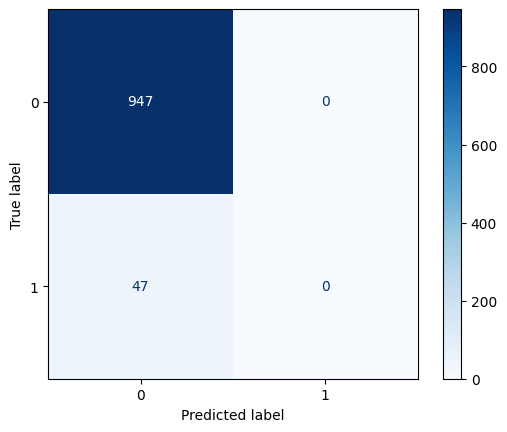

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_scaled) # generating the predicted values (0 or 1)

cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

The confusion matrix shows that the root of the low AUC-PR score was the model guessing 'no stroke' for every sample. This is surprising given this didn't happen in the training set. Clearly this model needs some serious work to improve the type II error. Considerations for implementing this are given in the reflection.